In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, DoubleType, FloatType, IntegerType
from hyperopt import fmin, tpe, hp, Trials, SparkTrials
from hyperopt.pyll import scope
import numpy as np
import mlflow
import mlflow.xgboost
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve, auc, precision_recall_curve, brier_score_loss
from sklearn.model_selection import cross_validate, StratifiedKFold
import matplotlib.pyplot as plt 
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from hyperopt import hp
import pandas as pd
import seaborn as sn
import shap
import urllib3

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)  # CCW has self-signed certificates

# utility function for computing F-scores
def Fbeta(beta, precision, recall):
    return (beta*beta + 1)*precision*recall / (beta*beta*precision + recall)

## Load data

These cells load the pre-built input data (e.g., post-SMOTE processing) and produce train and test splits. We call `cache()` on both `train` and `test` to improve performance over multiple runs.

Note that to mirror the Logistic Regression model, we only use train/test, rather than train/val/test, due to the small number of positive examples in the data as a whole.

In [ ]:
## using simple train/test split due to small number of positive samples
train_split_sql = "MOD(bene_id, 20) < 14"
test_split_sql = "MOD(bene_id, 20) >= 14"

# NB. Make sure to modify input_data_descriptor and tags to match the input data so mlflow will record it
train = spark.table("eldb.opioid_SA_LA_hosp_final_tsfresh_and_demos_train_smotenctomek")
test = spark.table("eldb.opioid_SA_LA_hosp_final_tsfresh_and_demos_ohe").where(test_split_sql).drop("bene_id")
input_data_descriptor = 'xgboost_tsfresh_smotenctomek'
run_tags = {'model':'xgboost',
                  'source_table': 'tsfresh_and_demos',
                  'resampler': 'smotenctomek'}

train.cache().count()

Out[109]: 909256

In [ ]:
test.cache().count()

Out[110]: 196315

## Define hyperparameter search

In this cell we set up a `BinaryClassificationEvaluator` to compute the area under the P-R curve. The columns it references are computed/combined in the model runs.

We also establish a search space of parameters to vary and an objective function to train and test a model using a random draw of parameters from the search space. The objective function itself returns 1-areaUnderROC to represent the "loss" that hyperopt is attempting to minimize. 

Although we use aucPR in the final training and evaluation, testing showed that using aucROC for the objective function gives better results.

In [ ]:
# Manually log 
mlflow.autolog(disable=True)
mlflow.pyspark.ml.autolog(disable=True)

# define evaluation metric for optimal thresholds
binaryClassificationEvaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="labels", metricName='areaUnderPR')

def objective_function(params):
  
  # set the hyperparameters that we want to tune
  learning_rate = params["learning_rate"]
  gamma = params["gamma"]
  max_depth = int(params["max_depth"])
  reg_alpha = params["reg_alpha"]
  reg_lambda = params["reg_lambda"]
  with mlflow.start_run():
  #if True:
    xgb_model = xgb.XGBClassifier(
                              objective="binary:logistic", 
                              eval_metric='aucpr',
                              tree_method="hist",
                              use_label_encoder=False,
                              subsample=0.5,
                              learning_rate=learning_rate,
                              gamma=gamma,
                              max_depth=max_depth,
                              reg_alpha=reg_alpha,
                              reg_lambda=reg_lambda,
                             ) 
    estimator = xgb_model.fit(train.drop('labels').toPandas(), train.select('labels').toPandas().values.ravel())

    preds = estimator.predict_proba(test.drop("labels").toPandas()).astype('float64')
    prediction_pddf = (pd.concat([pd.DataFrame({'rawPrediction': preds[:, 1]}),
                                  test.select('labels').toPandas()],
                                 axis=1))
    prauc = binaryClassificationEvaluator.evaluate(spark.createDataFrame(prediction_pddf))
    fpr, tpr, thresholds = roc_curve(prediction_pddf['labels'], prediction_pddf['rawPrediction'], pos_label=1);
    roc_auc = auc(fpr, tpr)
    mlflow.log_params(params)
    mlflow.log_metric("pr-auc", prauc)
    mlflow.log_metric("roc-auc", roc_auc)
    
  return 1-roc_auc

search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
  'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
  'gamma': hp.loguniform('gamma', -3, 0)
}

## Run hyperparameter search and train "best" model

With the objective funciton and search space defined, we now perform the search: `fmin()` returns a dictionary of the best hyperparameters according to our objective function. With those "best" parameters, we first re-train a new XGBoost estimator, then run a 5-fold (`cv=5`) cross-validation on the training data set to tune the final model for best ultimate area-under-PR.

The best model from the cross-validation is then used to compute the model metrics and log them to the mlflow experiment. Generally, the same metrics are used as produced by the Logistic Regression model; as there, the precision is quite poor and so there are many zeros in accuracy/precision/recall/F1/F2. Similarly, Brier scores for the model as a whole and subgroups are computed and logged. (This cross-validation uses the scikit-learn methods and so is not Spark-aware--it runs on the driver node.
)

Particular to the XGBoost model, feature importance is plotted for the top 20 features, measured by gain (average gain of splits using the feature), coverage (average number of samples affected by a split on the feature), and weight (number of times this feature appears in a tree).

Additional plots are produced using the SHAP(SHapley Additive exPlanations) package:
- A "beeswarm" summary plot of the top features' impact
- Interaction plots of the top feature with the next 3 most-important features

Note: for SHAP we compute SHAP values using a subsample of 5000 examples. This is because the large number of samples, combined with the very low values, can cause additivity problems due to numerical underflow. (The additivity check is known to be overly sensitive in some versions of the SHAP package, so we still disable it anyway.)

0%| | 0/100 [00:00<?, ?trial/s, best loss=?] 1%| | 1/100 [00:37<1:01:07, 37.04s/trial, best loss: 0.22991210391126782] 2%|▏ | 2/100 [01:12<59:15, 36.28s/trial, best loss: 0.22991210391126782]  3%|▎ | 3/100 [01:58<1:05:33, 40.55s/trial, best loss: 0.1524604501212844] 4%|▍ | 4/100 [02:45<1:09:13, 43.26s/trial, best loss: 0.14833676050089983] 5%|▌ | 5/100 [03:19<1:02:52, 39.71s/trial, best loss: 0.14833676050089983] 6%|▌ | 6/100 [03:59<1:02:15, 39.74s/trial, best loss: 0.14833676050089983] 7%|▋ | 7/100 [04:38<1:01:12, 39.49s/trial, best loss: 0.14833676050089983] 8%|▊ | 8/100 [05:16<59:49, 39.02s/trial, best loss: 0.14833676050089983]  9%|▉ | 9/100 [05:57<1:00:08, 39.65s/trial, best loss: 0.14833676050089983] 10%|█ | 10/100 [06:33<58:05, 38.72s/trial, best loss: 0.14833676050089983]  11%|█ | 11/100 [07:13<58:03, 39.14s/trial, best loss: 0.14833676050089983] 12%|█▏ | 12/100 [07:55<58:44, 40.05s/trial, best loss: 0.14833676050089983] 13%|█▎ | 13/100 [08:40<1:00:09, 41.49s/trial, best loss: 0.14833676050089983] 14%|█▍ | 14/100 [09:25<1:00:53, 42.48s/trial, best loss: 0.14511269225998846] 15%|█▌ | 15/100 [10:04<58:53, 41.58s/trial, best loss: 0.14511269225998846]  16%|█▌ | 16/100 [10:43<57:06, 40.80s/trial, best loss: 0.14511269225998846] 17%|█▋ | 17/100 [11:35<1:01:04, 44.15s/trial, best loss: 0.14511269225998846] 18%|█▊ | 18/100 [12:14<58:11, 42.58s/trial, best loss: 0.14511269225998846]  19%|█▉ | 19/100 [13:03<1:00:04, 44.49s/trial, best loss: 0.14511269225998846] 20%|██ | 20/100 [13:39<55:57, 41.97s/trial, best loss: 0.14511269225998846]  21%|██ | 21/100 [14:35<1:00:31, 45.97s/trial, best loss: 0.14511269225998846] 22%|██▏ | 22/100 [15:31<1:03:56, 49.19s/trial, best loss: 0.14511269225998846] 23%|██▎ | 23/100 [16:17<1:01:35, 47.99s/trial, best loss: 0.14511269225998846] 24%|██▍ | 24/100 [17:01<59:21, 46.86s/trial, best loss: 0.14511269225998846]  25%|██▌ | 25/100 [17:59<1:02:49, 50.26s/trial, best loss: 0.14511269225998846] 26%|██▌ | 26/100 [18:47<1:01:04, 49.52s/trial, best loss: 0.14511269225998846] 27%|██▋ | 27/100 [19:38<1:00:58, 50.12s/trial, best loss: 0.14511269225998846] 28%|██▊ | 28/100 [20:25<58:59, 49.16s/trial, best loss: 0.14511269225998846]  29%|██▉ | 29/100 [21:15<58:32, 49.47s/trial, best loss: 0.14511269225998846] 30%|███ | 30/100 [22:07<58:37, 50.25s/trial, best loss: 0.14511269225998846] 31%|███ | 31/100 [22:56<57:07, 49.68s/trial, best loss: 0.14511269225998846] 32%|███▏ | 32/100 [23:35<52:42, 46.50s/trial, best loss: 0.14511269225998846] 33%|███▎ | 33/100 [24:20<51:30, 46.13s/trial, best loss: 0.14511269225998846] 34%|███▍ | 34/100 [25:07<51:01, 46.38s/trial, best loss: 0.14511269225998846] 35%|███▌ | 35/100 [25:59<51:53, 47.90s/trial, best loss: 0.14511269225998846] 36%|███▌ | 36/100 [26:41<49:22, 46.28s/trial, best loss: 0.14511269225998846] 37%|███▋ | 37/100 [27:29<49:02, 46.71s/trial, best loss: 0.14511269225998846] 38%|███▊ | 38/100 [27:51<40:41, 39.38s/trial, best loss: 0.14511269225998846] 39%|███▉ | 39/100 [28:38<42:19, 41.63s/trial, best loss: 0.14511269225998846] 40%|████ | 40/100 [29:22<42:24, 42.40s/trial, best loss: 0.14511269225998846] 41%|████ | 41/100 [30:05<41:58, 42.68s/trial, best loss: 0.14511269225998846] 42%|████▏ | 42/100 [30:52<42:18, 43.77s/trial, best loss: 0.14511269225998846] 43%|████▎ | 43/100 [31:43<43:45, 46.06s/trial, best loss: 0.14511269225998846] 44%|████▍ | 44/100 [32:24<41:34, 44.54s/trial, best loss: 0.14511269225998846] 45%|████▌ | 45/100 [33:05<39:53, 43.51s/trial, best loss: 0.14511269225998846] 46%|████▌ | 46/100 [33:47<38:43, 43.03s/trial, best loss: 0.14511269225998846] 47%|████▋ | 47/100 [34:24<36:25, 41.23s/trial, best loss: 0.14511269225998846] 48%|████▊ | 48/100 [35:13<37:47, 43.60s/trial, best loss: 0.14511269225998846] 49%|████▉ | 49/100 [35:59<37:35, 44.22s/trial, best loss: 0.14511269225998846] 50%|█████ | 50/100 [36:44<37:07, 44.55s/trial, best loss: 0.14511269225998846] 51%|█████ | 51/100 [37:34<37:37, 46.

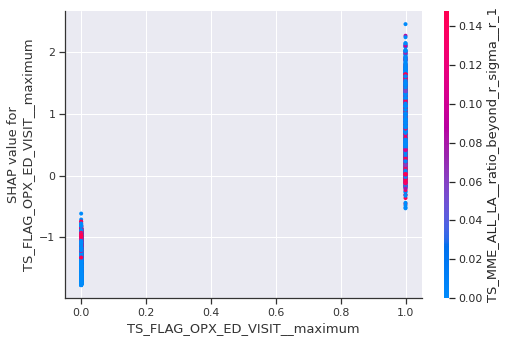

In [ ]:
# Manually log to cut down on the mlflow noise
mlflow.autolog(disable=True)
mlflow.pyspark.ml.autolog(disable=True)
mlflow.xgboost.autolog(disable=True)


# Find best value of hyperparameters (guideline = 20 x n_params)
num_evals = 100

trials = Trials()
best_hyperparam = fmin(fn=objective_function, 
                       space=search_space,
                       algo=tpe.suggest, 
                       max_evals=num_evals,
                       trials=trials,
                       rstate=np.random.default_rng(4231))

with mlflow.start_run():
  mlflow.set_tags(run_tags)
  best_learning_rate = best_hyperparam["learning_rate"]
  best_gamma = best_hyperparam["gamma"]
  best_max_depth = int(best_hyperparam["max_depth"])
  best_reg_alpha = best_hyperparam["reg_alpha"]
  best_reg_lambda = best_hyperparam["reg_lambda"]
  xgb_model = xgb.XGBClassifier( 
                              objective="binary:logistic", 
                              eval_metric='aucpr',
                              tree_method='hist',
                              subsample=0.5,
                              use_label_encoder=False,
                              learning_rate=best_learning_rate,
                              gamma=best_gamma,
                              reg_alpha=best_reg_alpha,
                              reg_lambda=best_reg_lambda,
                              max_depth=best_max_depth
                             ) 
  
  # now retrain using the best hyperparameters
  
  # Cross validation to get the best fit with the best hyperparameters
  scores = cross_validate(xgb_model, train.drop('labels').toPandas(), train.select('labels').toPandas(), 
                          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=2134), return_estimator=True)
  bestModel = scores['estimator'][np.argmax(scores['test_score'])]
  mlflow.xgboost.log_model(bestModel.get_booster(), input_data_descriptor)
  
  probs = bestModel.predict_proba(test.drop("labels").toPandas()).astype('float64')
  preds = bestModel.predict(test.drop("labels").toPandas())
  prediction_pddf = (pd.concat([pd.DataFrame({'rawPrediction': probs[:, 1], 
                                              'prediction': preds}),
                                test.select('labels').toPandas()],
                               axis=1))
  
  # Get precision-recall AUC
  predDF = spark.createDataFrame(prediction_pddf)
  prauc = binaryClassificationEvaluator.evaluate(predDF)
  
  # Find the optimal threshold using geometric mean (note: there is virtually no precision in the model, making it difficult to use this metric for deriving a decent threshold.
  fpr, tpr, thresholds = roc_curve(prediction_pddf['labels'], prediction_pddf['prediction'], pos_label=1);
  roc_auc = auc(fpr, tpr) # get roc_auc while we're at it
  gmean = np.sqrt(tpr * (1-fpr))
  index = np.argmax(gmean)
  thresholdOpt = round(thresholds[index], ndigits = 8)
  mlflow.log_metric("optimal_gmean_threshold", thresholdOpt) 
  
  # Calculate the elements of the confusion matrix
  TN = predDF.filter(f'prediction < {thresholdOpt} AND labels = 0').count()
  TP = predDF.filter(f'prediction >= {thresholdOpt} AND labels = 1').count()
  FN = predDF.filter(f'prediction < {thresholdOpt} AND labels = 1').count()
  FP = predDF.filter(f'prediction >= {thresholdOpt} AND labels = 0').count()

  try:
    accuracy = (TN + TP) / (TN + TP + FN + FP) 
  except: accuracy = 0
  try:
    precision = TP / (TP + FP)
  except: precision = 0
  try:
    recall = TP / (TP + FN)
  except: recall =0
  try:
    F1 =  Fbeta(1, precision, recall)
  except: F1=0
  try:
    F2 =  Fbeta(2, precision, recall)
  except: F2=0
  
  # Calculate Brier Score
  predDF = predDF.withColumn('difference', F.col('labels') - F.col('prediction'))
  predDF = predDF.withColumn('squared_difference', F.pow(F.col('difference'), F.lit(2).astype(IntegerType())))
  mse = predDF.groupBy().agg(F.avg(F.col('squared_difference')).alias('mse'))
  brier_score = mse.collect()[0][0]

  # Log param and metrics for the final model
  mlflow.log_param("learning_rate", best_learning_rate)
  mlflow.log_param("gamma", best_gamma)
  mlflow.log_param("reg_alpha", best_reg_alpha)
  mlflow.log_param("reg_lambda", best_reg_lambda)
  mlflow.log_param("max_depth", best_max_depth)
  mlflow.log_metric("pr-auc", prauc)
  mlflow.log_metric("roc-auc", roc_auc)
  mlflow.log_metric("TN", TN)
  mlflow.log_metric("TP", TP)
  mlflow.log_metric("FN", FN)
  mlflow.log_metric("FP", FP)
  mlflow.log_metric("accuracy", accuracy)
  mlflow.log_metric("precision", precision)
  mlflow.log_metric("recall", recall)
  mlflow.log_metric("F1", F1)
  mlflow.log_metric("F2", F2)
  mlflow.log_metric("brier_score", brier_score)
  
  # PR CURVE
  precision, recall, thresholds = precision_recall_curve(prediction_pddf['labels'], prediction_pddf['prediction'], pos_label=1)
  
  pr_curve_fig = plt.figure(figsize=(5,5))
  plt.plot(precision, recall, label='P-R curve (area = %0.2f)' % prauc) # re-using this rather than re-computing
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Recall (TP/(TP+FN))')
  plt.ylabel('Precision (TP/(TP+FP))')
  plt.title('Precision-Recall Curve')
  plt.legend(loc="lower right")
  plt.tight_layout()
  mlflow.log_figure(pr_curve_fig, 'pr_curve_fig.png')
  
  # Confusion Matrix
  array = [[TN, FP], [FN, TP]]

  df_cm = pd.DataFrame(array, )
  s = plt.figure(figsize=(10,7))

  sn.set(font_scale=1.4) # for label size
  s = sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cbar=False, cmap="YlGnBu") # font size
  s.set(xlabel='Predicted', ylabel='Actual')

  for t in s.texts:
    t.set_text('{:,d}'.format(int(t.get_text())))
  
  mlflow.log_figure(s.get_figure(), 'confusion-matrix.png')
  

  # XGBoost Feature Importance
  plt.close('all')
  fig, axes = plt.subplots(3,1,figsize=(10,18))
  for (importance, ax) in zip(['weight', 'cover', 'gain'], axes):
    xgb.plot_importance(bestModel, max_num_features=20, importance_type=importance, title=f"Feature importance ({importance})", ax=ax)
    plt.tight_layout()
  mlflow.log_figure(plt.gcf(), "xgb_feature_importance.png")
  
  # Brier Scores for subgroups
  prediction_pddf = pd.concat([prediction_pddf, test.drop('labels').toPandas()], axis=1).rename(columns = {'labels':'target', 'prediction':'preds'})
  dataset = prediction_pddf
  brier_scores = {}
  for col in dataset.columns:
    if "STATIC" in col:
      cur_df = dataset[dataset[col] == 1]
      if len(cur_df) > 0:
        preds = cur_df["preds"].to_numpy()
        labels = cur_df["target"].to_numpy()
        brier_score = brier_score_loss(labels, preds)
        brier_scores[col] = brier_score
      else:
        print(f"no positive examples for {col}")

  # log brier scores for subgroups
  preds = dataset["preds"].to_numpy()
  labels = dataset["target"].to_numpy()
  full_brier_score = brier_score_loss(labels, preds)
  normalized_dict = {}
  for key in brier_scores:
    normalized_dict[f"{key}_normalized"] = full_brier_score/brier_scores[key]
  brier_scores["all"] = full_brier_score
  brier_scores.update(normalized_dict)
  brier_scores = brier_scores
  brierdf = pd.DataFrame.from_dict(brier_scores, orient='index', columns=['brier_score'])
  brierdf.to_html('brier_score_subgroups.html')
  mlflow.log_artifact('brier_score_subgroups.html')
  
  # SHAP Explanations
  plt.close('all') # let shap draw its own figure
  plt.figure(figsize=(15,10))
  # subsample the test set for SHAP
  shap_X = test.drop('labels').toPandas() #.sample(n=5000, random_state=2134)
  shap_explainer = shap.TreeExplainer(bestModel)
  shap_values = shap_explainer.shap_values(shap_X, check_additivity=False)
  shap.summary_plot(shap_values, shap_X, plot_size=(15,10), show=False)
  plt.tight_layout()
  mlflow.log_figure(plt.gcf(), 'shap_summary.png')
  
  inds = shap.approximate_interactions("rank(0)", shap_values, shap_X)
  for i in range(3):
    plt.close('all')
    plt.figure(figsize=(10,10))
    shap.dependence_plot("rank(0)", shap_values, shap_X, interaction_index=inds[i], show=False)
    plt.tight_layout()
    mlflow.log_figure(plt.gcf(), f"shap_interactions_0_{i}.png")

## Additional SHAP Plots
These SHAP plots are given as examples of ways SHAP can be used to explore the model.

The Force Plot shows the relative impact of each feature on a particular example's model output (in this case, the first example in the test set).

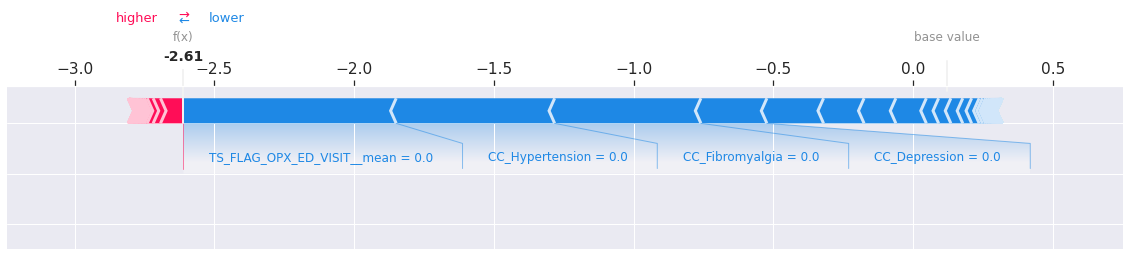

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], matplotlib=True, show=False).savefig('exp.png')


The Decision Plot is another means of showing the same information.

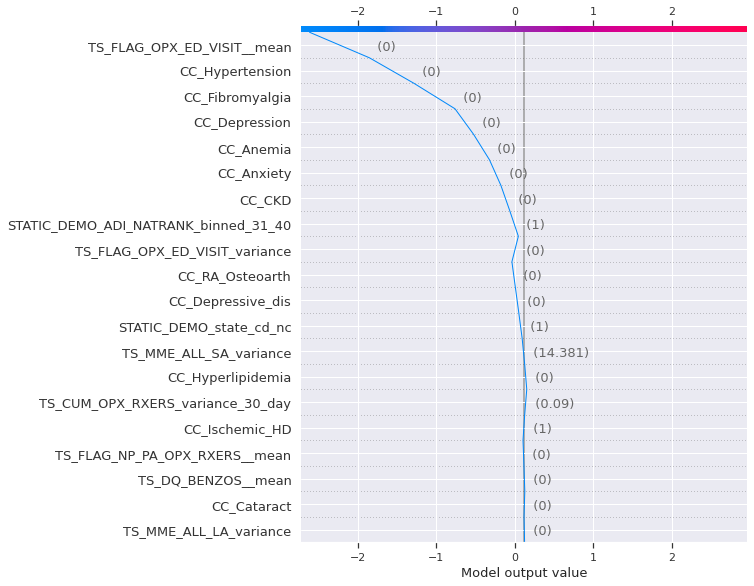

In [ ]:
shap.decision_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
shap.plots.heatmap(explainer(X[:1000]))